# Example Notebook to fit a microlensing event

The procedure is:
1. Estimate the point lens parameters (`t_0`, `u_0`, `t_E`) from the light curve.
2. Fit a point lens model (excluding the planetary perturbation).
3. Estimate the planet parameters (`s`, `alpha`) from the light curve.
4. Search for the best planetary model using a grid of `s`, `q` (fixed parameters); fits for `rho` and `alpha` but holds the PSPL parameters (`t_0`, `u_0`, `t_E`) fixed.

This notebook is setup to run on a simulated data file: `WFIRST_1827.dat`. To run it on a different data file requires some limited user interaction indicated by `***`:
1. Set `filename` and `path`
2. Set the plot limits: `t_min`, `t_max`
3. Define the time window of the planetary perturbation: `t_planet_start`, `t_planet_stop`

The goal of the notebook is to demonstrate the procedure and run quickly, so it is not robust. The fitting procedure is very simplistic and relies on assuming this is a Gould & Loeb (1996) type planet, which means
- It is a planetary caustic perturbation
- It is well described as a _perturbation_, which means
  - The perturbation data can be isolated from the underlying PSPL event 
  - The location of the planet can be estimated from the location of the images at the time of the perturbation
  
This notebook will **not** perform well for:
- central caustic planets (u_0 << 1 and/or u_0 < rho)
- resonant caustic planets (s ~ 1)
- binaries (i.e. the assumption that q << 1 is false)

Simple modifications that could improve performance indicated by `*`:
- Change the `magnification_methods`, i.e. the method used and the time range it is used for.
- Change the minimization routine in `fit_model()` (This notebook is set up to use a 'Nelder-Mead' simplex algorithm. Simplex algorithms are known to perform poorly on microlensing events.)
- Change the size of the grid or the grid steps: `delta_log_s`, `delta_log_q`, `grid_log_s`, `grid_log_q`

In [1]:
# Import packages
from datetime import datetime
start_time = datetime.now() # initialize timer
import MulensModel as mm
import matplotlib.pyplot as pl
import numpy as np
import scipy.optimize as op
import os
import astropy.units as u

In [2]:
# Define fitting functions

def chi2_fun(theta, event, parameters_to_fit):
    """                                                                         
    Chi2 function. Changes values of the parameters and recalculates chi2.
    
    event = a MulensModel.Event
    parameters_to_fit = list of names of parameters to be changed
    theta = values of the corresponding parameters
    """
    # key = the name of the MulensModel parameter
    for (index, key) in enumerate(parameters_to_fit):
        if (key == 't_E' or key =='rho') and theta[index] < 0.:
            return np.inf
        setattr(event.model.parameters, key, theta[index])
    return event.get_chi2()

def fit_model(event, parameters_to_fit):
    """
    Fit an "event" with "parameters_to_fit" as free parameters.
    
    event = a MulensModel event
    parameters_to_fit = list of parameters to fit
    """
    # Take the initial starting point from the event.
    x0 = []
    for key in parameters_to_fit:
        value = getattr(event.model.parameters, key)
        if isinstance(value, u.Quantity):
            x0.append(value.value)
        else:
            x0.append(value)

    # *Execute fit using a 'Nelder-Mead' algorithm*
    result = op.minimize(
        chi2_fun, x0=x0, args=(event, parameters_to_fit),
        method='Nelder-Mead')

    return result

In [9]:
# ***Read in data file***
#path = os.path.join(mm.MODULE_PATH, "data")
path = "../data"
filename = 'WFIRST_1827.dat' # Planet file
file = os.path.join(path, filename)
data = mm.MulensData(file_name=file)
file

'../data/WFIRST_1827.dat'

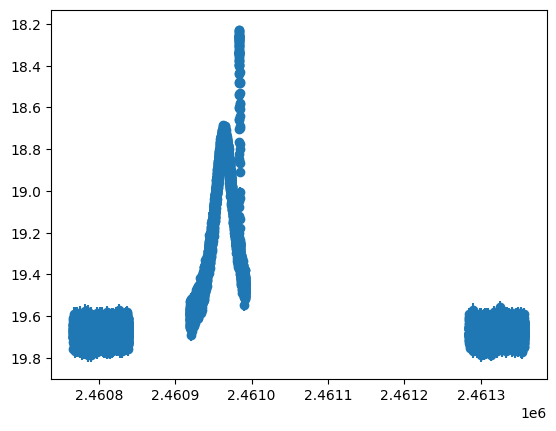

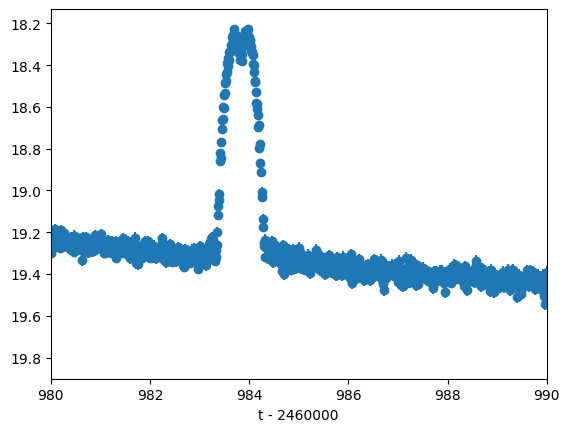

In [10]:
# Plot the data
pl.errorbar(data.time, data.mag, yerr=data.err_mag, fmt='o')
pl.gca().invert_yaxis()
pl.show()

# ***Define plot limits for a zoom (of the planetary perturbation)***
(t_min, t_max) = (2460980, 2460990)

# Plot a zoom of the data
pl.errorbar(data.time - 2460000., data.mag, yerr=data.err_mag, fmt='o')
pl.xlim(t_min - 2460000., t_max - 2460000.)
pl.xlabel('t - 2460000')
pl.gca().invert_yaxis()
pl.show()

In [11]:
# ***Set time range of planetary perturbation (including 2460000).***
(t_planet_start, t_planet_stop) = (2460982., 2460985.)

# *Set the magnification methods for the planet model*
# VBBL method will be used between t_planet_start and t_planet_stop, 
# and point_source_point_lens will be used everywhere else.
magnification_methods = [
    0., 'point_source_point_lens', 
    t_planet_start, 'VBBL', t_planet_stop, 
    'point_source_point_lens', 2470000.]

In [12]:
# Flag data related to the planet
flag_planet = (data.time > t_planet_start) & (data.time < t_planet_stop) | np.isnan(data.err_mag)

# Exclude those data from the fitting (for now)
data.bad = flag_planet

In [13]:
# Estimate point lens parameters assuming zero blending
# 
# Equation for point lens magnification:
#
# A(u) = (u^2 + 2) / (u * sqrt(u^2 + 4))
#
# where
# 
# u = sqrt(u_0^2 + tau^2) and tau = (t - t_0) / t_E
#
# Thus, the light curve is defined by 3 variables: t_0, u_0, t_E
#

# Estimate t_0 (time of peak magnification)
index_t_0 = np.argmin(data.mag[np.invert(flag_planet)])
t_0 = data.time[index_t_0]

# Estimate u_0
baseline_mag = np.min([data.mag[0], data.mag[-1]]) # A crude estimate
A_max = 10.**((data.mag[index_t_0] - baseline_mag) / -2.5)
u_0 = 1. / A_max # True in the high-magnification limit

# Estimate t_E by determining when the light curve is A(t) = 1.3 (i.e. delta_mag = 0.3)
t_1 = np.interp(
    baseline_mag - 0.3, data.mag[index_t_0:0:-1], data.time[index_t_0:0:-1])
t_E = np.abs((t_0 - t_1) / np.sqrt(1. - u_0**2))

Initial Guess
    t_0 (HJD)       u_0    t_E (d) 
2460962.36458  0.411823    22.8092 



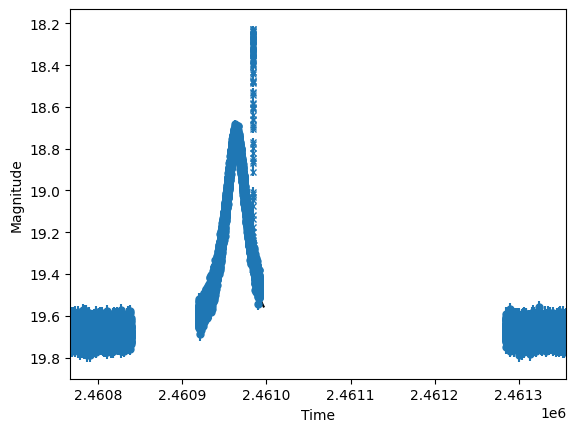

(array([7.80252182]), 0.7542833943450846)
[2.58000914]


/home/jones.7887/anaconda3/lib/python3.9/site-packages/MulensModel-2.14.1-py3.9-linux-x86_64.egg/MulensModel/model.py:1152: UserWarning: magnification() will be deprecated in favor of get_magnification()
  warnings.warn('magnification() will be deprecated in ' +


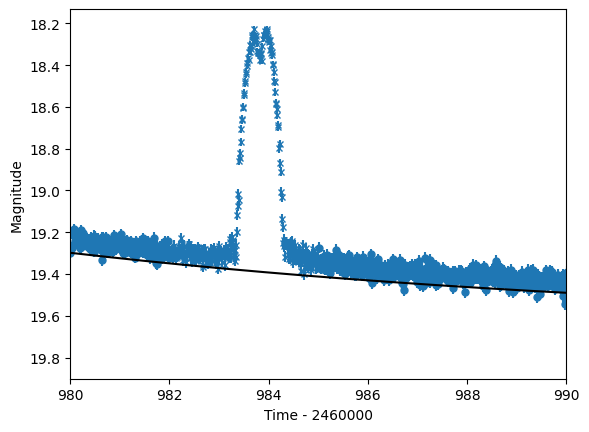

In [14]:
# Define the Point Lens Model
point_lens_model = mm.Model({'t_0': t_0, 'u_0': u_0, 't_E': t_E})
point_lens_event = mm.Event(datasets=data, model=point_lens_model)
print('Initial Guess')
print(point_lens_model)

# Plot (excluded data shown as 'X')
point_lens_event.plot_model(color='black')
point_lens_event.plot_data(show_bad=True)
pl.show()
print(point_lens_event.get_ref_fluxes())
print(point_lens_event.model.magnification(t_0))

point_lens_event.plot_model(subtract_2460000=True, color='black', zorder=10)
point_lens_event.plot_data(show_bad=True, subtract_2460000=True)
pl.xlim(t_min - 2460000., t_max - 2460000.)
pl.show()

Best-fit Point Lens
    t_0 (HJD)       u_0    t_E (d) 
2460963.60793  0.445415    24.5259 



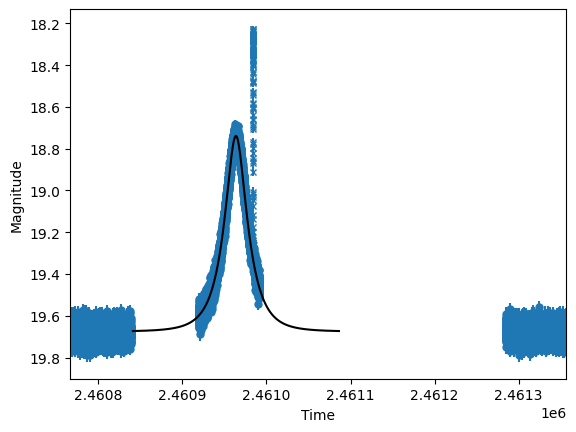

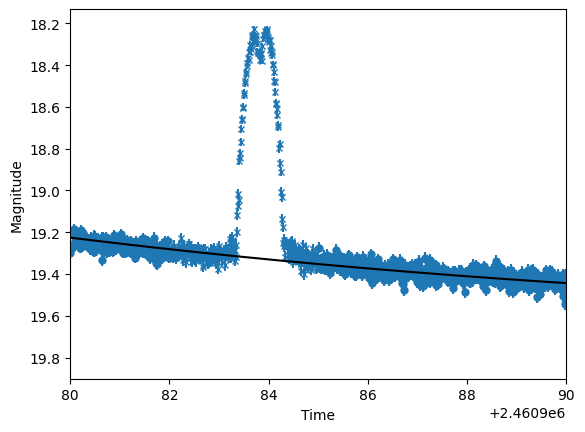

In [15]:
# Fit the Point Lens Model
result = fit_model(point_lens_event, parameters_to_fit=['t_0', 'u_0', 't_E'])
print('Best-fit Point Lens')
print(point_lens_event.model)

# Plot 
point_lens_event.plot_model(
    t_range=[point_lens_event.model.parameters.t_0 - 5. * point_lens_event.model.parameters.t_E,
             point_lens_event.model.parameters.t_0 + 5. * point_lens_event.model.parameters.t_E],
    color='black', zorder=10)
point_lens_event.plot_data(show_bad=True)
pl.show()

point_lens_event.plot_model(color='black', zorder=10)
point_lens_event.plot_data(show_bad=True)
pl.xlim(t_min, t_max)
pl.show()

In [16]:
# Un-flag planet data (include it in future fits)
data.bad = np.isnan(data.err_mag)

In [17]:
# Estimate s (projected separation) of the planet, alpha (angle of source trajectory)

# Approximate time of the planetary perturbation
t_planet = (t_planet_stop + t_planet_start) / 2.

# Position of the source at the time of the planetary perturbation
tau_planet = ((t_planet - point_lens_event.model.parameters.t_0) /
              point_lens_event.model.parameters.t_E)
u_planet = np.sqrt(
    point_lens_event.model.parameters.u_0**2 + tau_planet**2)

# Position of the lens images at the time of the planetary perturbation
# --> Estimate of the planet location
s_minus = 0.5 * (np.sqrt(u_planet**2 + 4.) - u_planet)
s_plus = 0.5 * (np.sqrt(u_planet**2 + 4.) + u_planet)

# Angle between the source trajectory and the binary axis
alpha_planet = np.rad2deg(-np.arctan2(
    point_lens_event.model.parameters.u_0, tau_planet))

    t_0 (HJD)       u_0    t_E (d)     rho         s            q alpha (deg) 
2460963.60793  0.445415    24.5259 0.00100   1.56450   0.00010000   -28.77442 



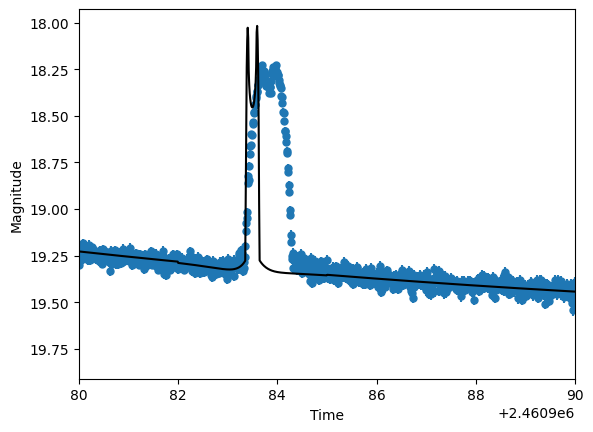

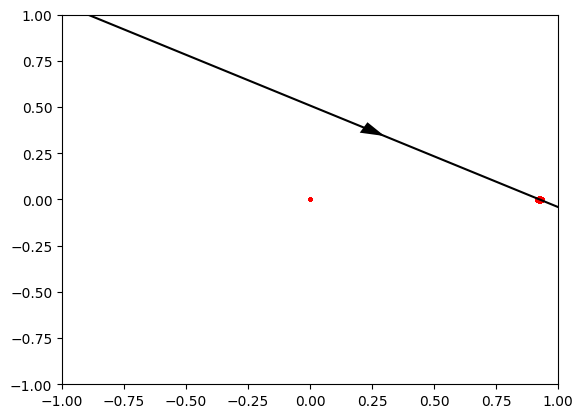

In [18]:
# Check the estimated model
# Note that there are two possibilities for s: s_plus and s_minus. 
# Only s_plus is tested here, but both are considered in the grid search below.

# Define the model
test_model = mm.Model({
    't_0': point_lens_event.model.parameters.t_0, 
    'u_0': point_lens_event.model.parameters.u_0,
    't_E': point_lens_event.model.parameters.t_E,
    'rho': 0.001,
    's': s_plus,
    'q': 10.**(-4),
    'alpha': alpha_planet})
test_model.set_magnification_methods(magnification_methods)
test_event = mm.Event(datasets=data, model=test_model)
print(test_event.model)

# Plot the model light curve
test_event.plot_data()
test_event.plot_model(t_range=[t_min, t_max], color='black', zorder=10)
pl.xlim(t_min, t_max)
pl.show()

# Plot the trajectory of the source relative to the caustics
test_event.model.plot_trajectory(color='black', caustics=True)
pl.xlim(-1,1)
pl.ylim(-1,1)
pl.show()
# It doesn't have to be perfect, but there should be a planetary perturbation
# at around the time of the perturbation in the data. If there is no perturbation
# and/or the source trajectory doesn't pass very near/through the caustics, there is some 
# problem with the model and the fit will likely fail.

In [19]:
# Using the Point Lens fit as input, search for a planetary solution
#
# Grid parameters: s (log), q (log)
# Fit parameters: rho, alpha
# PSPL parameters: t_0, u_0, t_E
#

# *Define the grid*
delta_log_s = 0.01
delta_log_q = 0.25
grid_log_s = np.hstack(
    (np.arange(
        np.log10(s_minus) - 0.02, np.log10(s_minus) + 0.02, delta_log_s),
    np.arange(
        np.log10(s_plus) - 0.02, np.log10(s_plus) + 0.02, delta_log_s)))
grid_log_q = np.arange(-5, -2, delta_log_q)

# For each grid point, fit for rho, alpha
grid = np.empty((5, len(grid_log_s) * len(grid_log_q)))
i = 0
print('{0:>12} {1:>6} {2:>7} {3:>7} {4:>7}'.format('chi2', 's', 'q', 'alpha', 'rho'))
for log_s in grid_log_s:
    for log_q in grid_log_q:
        # The major and minor images are on opposite sides of the lens:
        if log_s < 0.:
            alpha = alpha_planet + 180.
        else:
            alpha = alpha_planet
            
        # Define the Model and Event
        planet_model = mm.Model({
            't_0': point_lens_event.model.parameters.t_0, 
            'u_0': point_lens_event.model.parameters.u_0,
            't_E': point_lens_event.model.parameters.t_E,
            'rho': 0.001,
            's': 10.**log_s,
            'q': 10.**log_q,
            'alpha': alpha})
        planet_model.set_magnification_methods(magnification_methods)
        planet_event = mm.Event(datasets=[data], model=planet_model)
            
        # Fit the Event
        result = fit_model(planet_event, parameters_to_fit=['rho', 'alpha'])
        if result.success:
            chi2 = planet_event.get_chi2()
        else:
            chi2 = np.inf
                
        # Print and store result of fit
        print('{0:12.2f} {1:6.4f} {2:7.5f} {3:7.2f} {4:7.5f}'.format(
            chi2, 10.**log_s, 10.**log_q, 
            planet_event.model.parameters.alpha, planet_event.model.parameters.rho))
        grid[0, i] = log_s
        grid[1, i] = log_q
        grid[2, i] = chi2
        grid[3, i] = planet_event.model.parameters.alpha.value
        grid[4, i] = planet_event.model.parameters.rho
            
        i += 1

        chi2      s       q   alpha     rho
   109586.37 0.6104 0.00001  159.35 deg 1.31518
   109585.95 0.6104 0.00002  196.69 deg 1.31535
   109585.74 0.6104 0.00003  181.28 deg 1.31572
   126747.42 0.6104 0.00006  155.68 deg 0.00001
   126556.87 0.6104 0.00010  155.77 deg 0.00001
   126225.28 0.6104 0.00018  155.94 deg 0.00000
   125659.70 0.6104 0.00032  156.21 deg 0.00000
   124727.26 0.6104 0.00056  156.66 deg 0.00001
   123259.45 0.6104 0.00100  157.33 deg 0.00000
   121042.73 0.6104 0.00178  158.36 deg 0.00000
   117874.67 0.6104 0.00316  159.99 deg 0.00000
   113713.56 0.6104 0.00562  162.38 deg 0.00000
   126749.97 0.6246 0.00001  153.66 deg 0.00002
   126597.70 0.6246 0.00002  153.85 deg 0.00001
   126366.23 0.6246 0.00003  154.09 deg 0.00001
   126027.83 0.6246 0.00006  154.41 deg 0.00000
   125553.95 0.6246 0.00010  154.84 deg 0.00000
   123280.88 0.6246 0.00018  154.14 deg 0.00001
   120869.05 0.6246 0.00032  154.65 deg 0.00000
   117317.41 0.6246 0.00056  155.38 deg 0.00

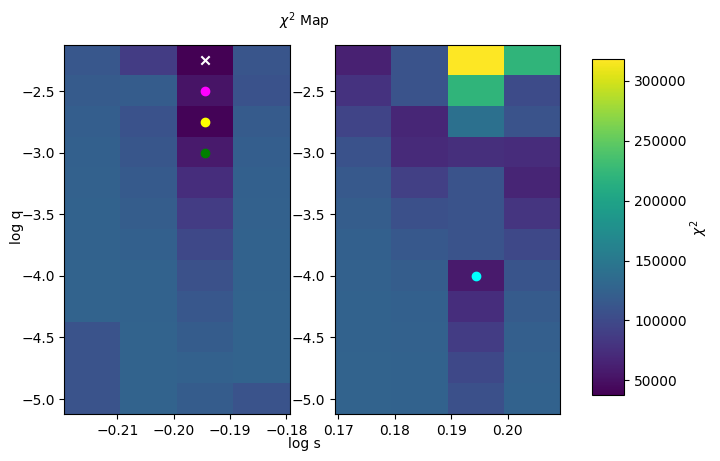

In [20]:
# Plot the grid

# Identify the best model(s)
index_best = np.argmin(np.array(grid[2,:]))
index_sorted = np.argsort(np.array(grid[2,:]))
n_best = 5 
colors = ['magenta', 'green', 'cyan','yellow']
if len(colors) < n_best - 1:
    raise ValueError('colors must have at least n_best -1 entries.')

# Plot the grid
fig, axes = pl.subplots(nrows=1, ncols=2)
n_plot = 0
for i in np.arange(2):
    if i == 0:
        index_logs = np.where(grid_log_s < 0.)[0]
        index_grid = np.where(grid[0, :] < 0.)[0]
    else:
        index_logs = np.where(grid_log_s >= 0.)[0]
        index_grid = np.where(grid[0, :] >= 0.)[0]
    
    # Plot chi2 map
    chi2 = np.transpose(
            grid[2, index_grid].reshape(len(index_logs), len(grid_log_q)))

    im = axes[i].imshow(
        chi2, aspect='auto', origin='lower',
        extent=[
            np.min(grid_log_s[index_logs]) - delta_log_s / 2., 
            np.max(grid_log_s[index_logs]) + delta_log_s / 2.,
            np.min(grid_log_q) - delta_log_q / 2., 
            np.max(grid_log_q) + delta_log_q / 2.],
        cmap='viridis', 
        vmin=np.min(grid[2,:]), vmax=np.nanmax(grid[2,np.isfinite(grid[2,:])]))  
    
    # Mark best values: best="X", other good="o"
    if index_best in index_grid:
        axes[i].scatter(grid[0, index_best], grid[1, index_best], marker='x', color='white')
    for j, index in enumerate(index_sorted[1:n_best]):
        if index in index_grid:
            axes[i].scatter(grid[0, index], grid[1, index], marker='o', color=colors[j - 1])
            
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

fig.text(0.5, 0.92, r'$\chi^2$ Map', ha='center')
fig.text(0.5, 0.04, 'log s', ha='center')
fig.text(0.04, 0.5, 'log q', va='center', rotation='vertical')
fig.text(1.1, 0.5, r'$\chi^2$', va='center', rotation='vertical')

pl.show()


In [21]:
def make_grid_model(index):
    """
    Define a Model using the gridpoint information + the PSPL parameters.
    
    index = index of the grid point for which to generate the model
    """
    model = mm.Model({
        't_0': point_lens_event.model.parameters.t_0, 
        'u_0': point_lens_event.model.parameters.u_0,
        't_E': point_lens_event.model.parameters.t_E,
        'rho': grid[4, index],
        's': 10.**grid[0, index],
        'q': 10.**grid[1, index],
        'alpha': grid[3, index]})
    model.set_magnification_methods(magnification_methods)
    return model

Best Models
    t_0 (HJD)       u_0    t_E (d)     rho         s            q alpha (deg) 
2460963.60793  0.445415    24.5259 0.00396   0.63918   0.00562341   162.72437 



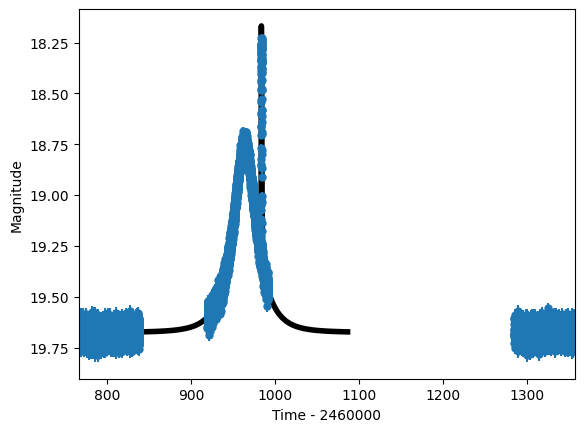

    t_0 (HJD)       u_0    t_E (d)     rho         s            q alpha (deg) 
2460963.60793  0.445415    24.5259 0.00138   0.63918   0.00177828   157.86409 

    t_0 (HJD)       u_0    t_E (d)     rho         s            q alpha (deg) 
2460963.60793  0.445415    24.5259 0.00746   0.63918   0.00316228   143.14089 

    t_0 (HJD)       u_0    t_E (d)     rho         s            q alpha (deg) 
2460963.60793  0.445415    24.5259 0.00131   0.63918   0.00100000   156.20417 

    t_0 (HJD)       u_0    t_E (d)     rho         s            q alpha (deg) 
2460963.60793  0.445415    24.5259 0.00337   1.56450   0.00010000   -28.40422 



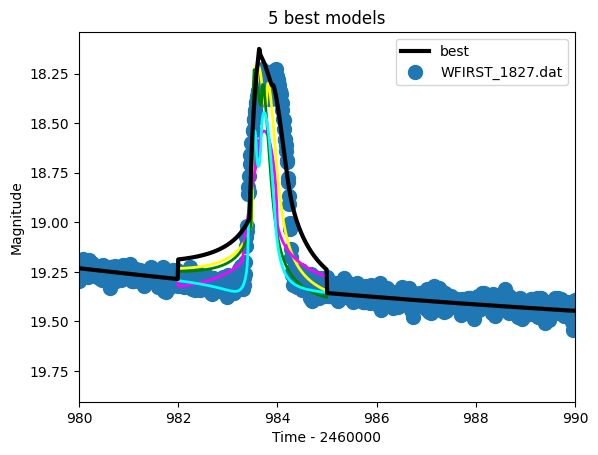

In [22]:
# Plot the best-fit model
best_fit_model = make_grid_model(index_best)
print('Best Models')
print(best_fit_model)
                   
best_fit_event = mm.Event(datasets=data, model=best_fit_model)
(f_source, f_blend) = best_fit_event.get_ref_fluxes()

# Whole model
t_range_whole = [best_fit_model.parameters.t_0 - 5. * best_fit_model.parameters.t_E,
                 best_fit_model.parameters.t_0 + 5. * best_fit_model.parameters.t_E]
best_fit_event.plot_model(t_range=t_range_whole, subtract_2460000=True, color='black', lw=4)
best_fit_event.plot_data(subtract_2460000=True)
pl.show()


# Zoom of planet
t_range_planet = [t_min, t_max]
# Best model = black
best_fit_event.plot_data(subtract_2460000=True, s=10, zorder=0)
best_fit_event.plot_model(
    t_range=t_range_planet, subtract_2460000=True, color='black', lw=3, label='best',
    zorder=10)
# Other models (color-coding matches grid)
for j, index in enumerate(index_sorted[1:n_best]):
    model = make_grid_model(index)
    model.plot_lc(
        t_range=t_range_planet, source_flux=f_source, blend_flux=f_blend,
        subtract_2460000=True, color=colors[j - 1], lw=2)
    print(model)
    
pl.title('{0} best models'.format(n_best))
pl.xlim(np.array(t_range_planet) - 2460000.)
pl.legend(loc='best')

pl.show()

In [ ]:
# Refine the n_best minima to get the best-fit solution
parameters_to_fit = ['t_0', 'u_0', 't_E', 'rho', 'alpha', 's', 'q']

fits = []
for index in index_sorted[:n_best]:
    model = make_grid_model(index)
    event = mm.Event(datasets=data, model=model)
    print(event.model)
    result = fit_model( 
        event, parameters_to_fit=parameters_to_fit)
    fits.append([result.fun, result.x])
    print(result)

    t_0 (HJD)       u_0    t_E (d)     rho         s            q alpha (deg) 
2460963.60793  0.445415    24.5259 0.00396   0.63918   0.00562341   162.72437 



In [ ]:
# Plot the best-fit model and output the parameters

# Extract best fit
chi2 = [x[0] for x in fits]
fit_parameters = [x[1] for x in fits]
index_best = np.argmin(chi2)

# Setup the model and event
parameters = {}
for i, parameter in enumerate(parameters_to_fit):
    parameters[parameter] = fit_parameters[index_best][i]
    
final_model = mm.Model(parameters)
final_model.set_magnification_methods(magnification_methods)
final_event = mm.Event(datasets=data, model=final_model)
print(final_event.model)
print('chi2: {0}'.format(final_event.get_chi2()))

# Plot the whole light curve
final_event.plot_data(subtract_2460000=True)
final_event.plot_model(t_range=t_range_whole, 
                       subtract_2460000=True, color='black', zorder=10)
pl.show()

# Plot zoom of the planet
final_event.plot_data(subtract_2460000=True)
final_event.plot_model(t_range=t_range_planet, subtract_2460000=True, color='black', zorder=10)
pl.xlim(t_min - 2460000., t_max - 2460000.)
pl.show()

In [ ]:
end_time = datetime.now()
print('Total Runtime: {0}'.format(end_time - start_time))